
# Introdução ao SVM
### Scikit-Learn (Linear, Polinomial e RBF)

Este notebook é um **artefato autocontido** para estudo de *Support Vector Machines (SVM)* com `scikit-learn`.  
Objetivos principais:
- Compreender o hiperplano de separação e a **margem máxima** (SVM linear).
- Visualizar **vetores de suporte** e sua influência na fronteira de decisão.
- Explorar **separação não linear** com *kernel* **Polinomial** e **RBF**.
- Comparar comportamentos e interpretar os gráficos gerados pelo modelo.

> Dica: execute as células em ordem. Cada seção inclui orientações passo a passo.



## 1) Preparação do ambiente
Nesta seção importamos bibliotecas e definimos funções auxiliares de visualização.


In [7]:
# Imports essenciais
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def plot_decision_boundary(clf, X, y, title):
    """
    Desenha os pontos (X, y), a fronteira de decisão e as margens (-1, 0, +1).
    - `clf` pode ser um Pipeline (com StandardScaler + SVC) ou um SVC puro.
    - A função usa `clf.decision_function` para contornar dados e,
      quando possível, plota os vetores de suporte no espaço original.
    """
    fig, ax = plt.subplots(figsize=(6,6))

    # Dispersão dos dados (sem cores fixas)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25)

    # Malha para os contornos
    xlim = (X[:,0].min() - 1, X[:,0].max() + 1)
    ylim = (X[:,1].min() - 1, X[:,1].max() + 1)
    xx = np.linspace(xlim[0], xlim[1], 300)
    yy = np.linspace(ylim[0], ylim[1], 300)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # A Pipeline expõe decision_function diretamente (aplica o scaler internamente)
    Z = clf.decision_function(xy).reshape(XX.shape)

    # Contornos em nível -1, 0 (hiperplano), +1
    ax.contour(XX, YY, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'])

    # Vetores de suporte em coordenadas originais, se possível
    svc = clf
    scaler = None
    if hasattr(clf, "named_steps"):
        svc = clf.named_steps.get("svc", None)
        scaler = clf.named_steps.get("standardscaler", None)

    if svc is not None and hasattr(svc, "support_vectors_"):
        sv = svc.support_vectors_
        # Se houve padronização, traz os vetores de suporte de volta ao espaço original
        if scaler is not None:
            sv = scaler.inverse_transform(sv)
        ax.scatter(sv[:, 0], sv[:, 1], s=100, facecolors='none', label="Vetores de suporte")
        ax.legend()

    ax.set_title(title)
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    plt.show()


def train_and_report(clf, X_train, X_test, y_train, y_test, title):
    """Treina, mede acurácia e mostra matriz de confusão do classificador."""
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia em teste — {title}: {acc:.3f}")
    # Remover os comentários a seguir após a aula de métricas de avaliação
    # fig, ax = plt.subplots(figsize=(5,5))
    # ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=ax, colorbar=False)
    # ax.set_title(f"Matriz de Confusão — {title}")
    # plt.show()
    return clf



## 2) Conjuntos de dados
Vamos criar dois conjuntos de dados 2D:
- **Blobs**: dados aproximadamente separáveis de forma linear (útil para SVM linear).
- **Círculos**: dados não linearmente separáveis no espaço original (motivação para kernels).


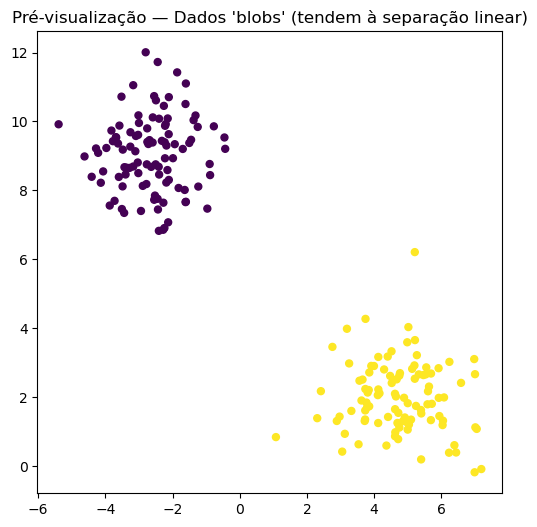

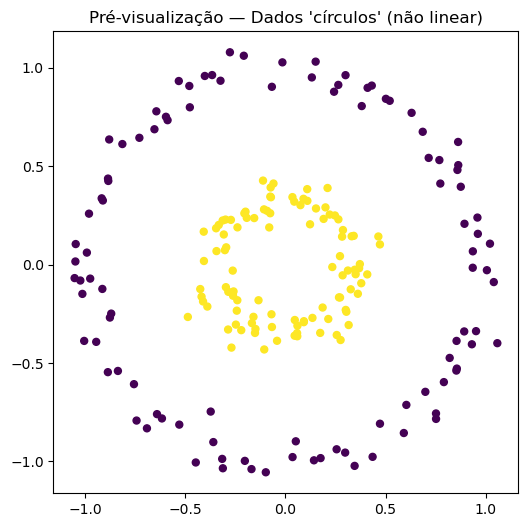

In [8]:

# Dataset 1: Linearmente separável (blobs)
X_lin, y_lin = datasets.make_blobs(
    n_samples=200, centers=2, cluster_std=1.1, random_state=42
)

# Dataset 2: Não linearmente separável (círculos concêntricos)
X_cir, y_cir = datasets.make_circles(
    n_samples=200, factor=0.35, noise=0.06, random_state=7
)

# Visualização rápida (um gráfico por vez)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_lin[:,0], X_lin[:,1], c=y_lin, s=25)
ax.set_title("Pré-visualização — Dados 'blobs' (tendem à separação linear)")
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_cir[:,0], X_cir[:,1], c=y_cir, s=25)
ax.set_title("Pré-visualização — Dados 'círculos' (não linear)")
plt.show()



## 3) SVM Linear — Hiperplano e Margem

- Objetivo: encontrar um **hiperplano** que separe as classes com **margem máxima**.
- O problema primal minimiza \( $\frac{1}{2}\lVert w\rVert^2$ \) sujeito às restrições \( $y_i (w\cdot x_i + b) \ge 1 $\).
- **Intuição**: margens maiores tendem a melhorar a **generalização**.

Vamos treinar um SVM linear e visualizar:
1. Pontos do conjunto;
2. **Fronteira de decisão** (nível 0);
3. **Margens** (níveis -1 e +1);
4. **Vetores de suporte** (destacados como círculos sem preenchimento).


Acurácia em teste — SVM Linear: 1.000


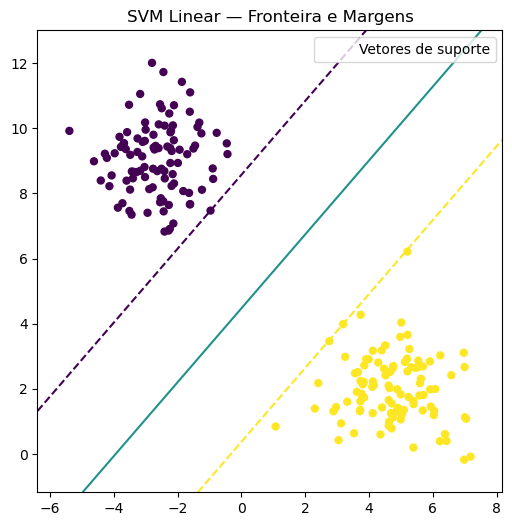

In [9]:

# Treino/Teste para o conjunto linear
Xtr, Xte, ytr, yte = train_test_split(X_lin, y_lin, test_size=0.3, random_state=0, stratify=y_lin)

# Pipeline para manter boas práticas (padronização + SVC linear)
svm_linear = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))

# Treina e reporta métricas
svm_linear = train_and_report(svm_linear, Xtr, Xte, ytr, yte, title="SVM Linear")

# Visualização das margens/hiperplano
plot_decision_boundary(svm_linear, X_lin, y_lin, "SVM Linear — Fronteira e Margens")



## 4) Kernel Polinomial — Fronteiras não lineares de ordem finita

- Quando a separação linear **não é suficiente**, podemos **mapear implicitamente** os dados para um espaço de maior dimensão.
- O *kernel polinomial* efetivamente considera **interações de ordem superior** entre atributos.
- Parâmetro relevante: `degree` (grau do polinômio).

Abaixo, aplicamos SVM com *kernel* polinomial aos dados em círculos.


Acurácia em teste — SVM Polinomial (grau 3): 0.667


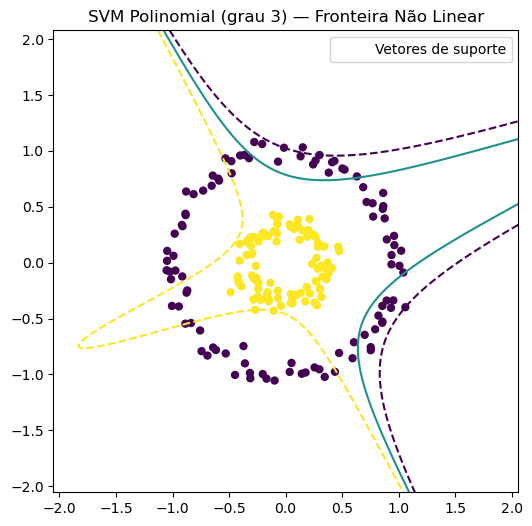

In [10]:

Xtr, Xte, ytr, yte = train_test_split(X_cir, y_cir, test_size=0.3, random_state=0, stratify=y_cir)

svm_poly = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, C=1.0))
svm_poly = train_and_report(svm_poly, Xtr, Xte, ytr, yte, title="SVM Polinomial (grau 3)")

plot_decision_boundary(svm_poly, X_cir, y_cir, "SVM Polinomial (grau 3) — Fronteira Não Linear")



## 5) Kernel RBF — Fronteiras flexíveis com similaridade radial

- O *kernel* **RBF** (Radial Basis Function) cria fronteiras **altamente flexíveis**, úteis quando a estrutura é complexa.
- Parâmetros relevantes: `gamma` (largura da base radial) e `C` (penalização a erros).
- **Heurística**: valores altos de `gamma` deixam a fronteira mais sinuosa (risco de sobreajuste); valores baixos suavizam a fronteira.

Aplicaremos o RBF no mesmo conjunto de círculos para comparação.


Acurácia em teste — SVM RBF (gamma=1.0, C=1.0): 1.000


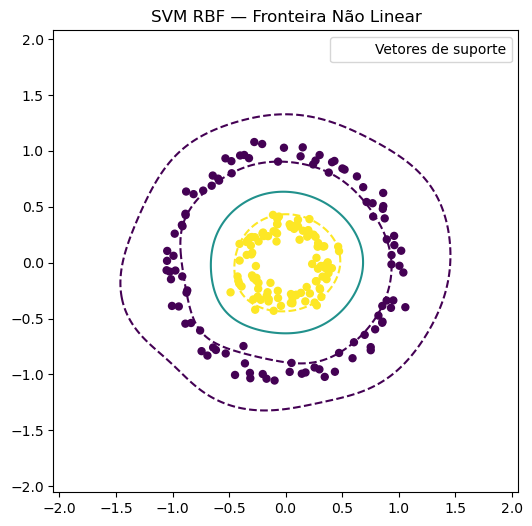

In [11]:

svm_rbf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma=1.0, C=1.0))
svm_rbf = train_and_report(svm_rbf, Xtr, Xte, ytr, yte, title="SVM RBF (gamma=1.0, C=1.0)")

plot_decision_boundary(svm_rbf, X_cir, y_cir, "SVM RBF — Fronteira Não Linear")



## 6) Comparação e Reflexão Didática

- **Linear**: funciona bem quando há uma separação aproximadamente reta; interpreta-se claramente a margem.
- **Polinomial**: introduz fronteiras curvilíneas de **ordem finita**, útil quando há interações moderadas entre atributos.
- **RBF**: fornece a maior flexibilidade; normalmente tem **bom desempenho prático**, mas exige cuidado na escolha de hiperparâmetros.

> Exercício sugerido: altere `C`, `degree` e `gamma` e observe como a fronteira muda.  
> Reflita sobre o impacto desses parâmetros na **complexidade do classificador** e no risco de **sobreajuste**.



## 7) Exercícios práticos (autoestudo)

1. **Ruído**: aumente `noise` no `make_circles` e verifique como os vetores de suporte e a acurácia mudam.
2. **Degrau polinomial**: teste `degree=2`, `degree=4` e compare as fronteiras.
3. **RBF fino x grosso**: varie `gamma` entre `0.1`, `0.5`, `1`, `5` e `10` e discuta o efeito.
4. **Métrica adicional**: inclua *precision*, *recall* e *F1-score* e analise os resultados. Volte aqui após a aula de métricas de avaliação.
5. **Projeção 2D**: gere um dataset 3D (três atributos) e use PCA para visualizar a separação em 2D. Sugestão avançada. Exige pesquisa e estudo do PCA.
